In [0]:
import pandas as pd
# Load Data
url = 'https://raw.githubusercontent.com/SEAnalytics/datasets/master/storypoint/IEEE%20TSE2018/dataset/mulestudio.csv'
raw_data = pd.read_csv(url)
raw_data.columns
raw_data.head(6)

,issuekey,title,description,storypoint
0,STUDIO-95,Support for request/reply,request/reply http://www.mulesoft.org/documen...,13
1,STUDIO-280,Cannot import a Studio project from Git withou...,Steps to reproduce: 1. Create a simple Mule...,3
2,STUDIO-382,Changes to Java code do not get hot deployed,Java source changes don't get picked up right ...,5
3,STUDIO-459,Unable to add a response when creating a secon...,Unable to add a response when creating a secon...,8
4,STUDIO-618,Namespaces in the XML view are not being remo...,When you add an element and then you remove it...,8
5,STUDIO-781,Would save time to be given the option to crea...,Add a button in the ClassFieldEditor to create...,5


In [0]:
# Check for missing values
raw_data.isnull().sum()


issuekey       0
title          0
description    0
storypoint     0
dtype: int64

In [0]:

# Examine storypoints summary statistics
raw_data.storypoint.describe()

count    732.000000
mean       6.396175
std        5.385687
min        1.000000
25%        3.000000
50%        5.000000
75%        8.000000
max       34.000000
Name: storypoint, dtype: float64

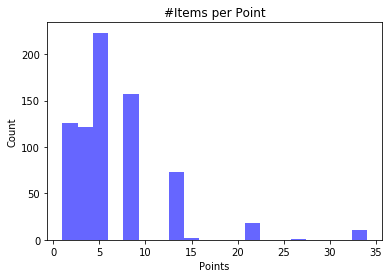

In [0]:
# Visualize number of storypoints distribution
import matplotlib.pyplot as plt
plt.hist(raw_data.storypoint, bins=20, alpha=0.6, color='b')
plt.title("#Items per Point")
plt.xlabel("Points")
plt.ylabel("Count")
plt.show()


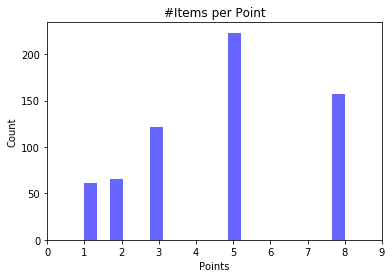

In [0]:
# Zoom in on most common data representing 75% of the dataset
import numpy as np
frequent_data = raw_data.query('storypoint <= 8')
plt.hist(frequent_data.storypoint, bins=20, alpha=0.6, color='b')
plt.title("#Items per Point")
plt.xlabel("Points")
plt.ylabel("Count")
plt.xticks(np.arange(0, 10, 1)) 
plt.show()

In [0]:
# Examine distribution in detail
raw_data.groupby('storypoint').size()

storypoint
1      61
2      65
3     121
5     223
8     157
13     73
15      2
21     18
26      1
34     11
dtype: int64

This shows that 5 the most common number of storypoints assigned to an issue/requirement.

In [0]:
################### Data Preprocessing ###################################

import nltk
from nltk.corpus import stopwords 
nltk.download('punkt')
nltk.download('stopwords')

issue_titles = raw_data['title']
issue_descriptions = raw_data['description']

# Create a list of strings, one for each title
titles_list = [title for title in issue_titles]
descriptions_list = [description for description in issue_descriptions]

# Collapse the list of strings into a single long string for processing
big_title_string = ' '.join(titles_list)

from nltk.tokenize import word_tokenize

# Tokenize the string into words
tokens = word_tokenize(big_title_string)

# Remove non-alphabetic tokens, such as punctuation
words = [word.lower() for word in tokens if word.isalpha()]

# Filter out stopwords
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
words = [word for word in words if not word in stop_words]





[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [0]:
import gensim
# Load word2vec model (trained on an enormous Google corpus)
model = gensim.models.KeyedVectors.load_word2vec_format('https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz', binary = True) 

# Check dimension of word vectors
model.vector_size

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


300

In [0]:
# Filter the list of vectors to include only those that Word2Vec has a vector for
vector_list = [model[word] for word in words if word in model.vocab]

# Create a list of the words corresponding to these vectors
words_filtered = [word for word in words if word in model.vocab]

# Zip the words together with their vector representations
word_vec_zip = zip(words_filtered, vector_list)

# Cast to a dict so we can turn it into a DataFrame
word_vec_dict = dict(word_vec_zip)
df = pd.DataFrame.from_dict(word_vec_dict, orient='index')
df.head(3)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299
support,-0.089844,-0.147461,-0.049561,0.002930,-0.335938,0.168945,-0.073242,-0.143555,0.106934,-0.020874,-0.114258,0.261719,-0.084961,0.227539,0.037598,-0.110840,0.029785,0.079102,-0.025391,-0.259766,0.080078,0.204102,0.087891,0.013672,0.059814,-0.149414,-0.152344,0.054932,-0.036865,-0.265625,0.244141,-0.092773,-0.130859,-0.069824,0.084473,0.055908,-0.065430,0.144531,-0.136719,-0.128906,...,-0.082031,-0.047119,-0.169922,0.167969,0.010010,0.099121,-0.000511,0.032471,-0.026489,-0.011414,-0.228516,-0.045898,0.183594,-0.111816,0.241211,-0.039062,-0.159180,-0.077637,-0.125977,-0.159180,-0.027466,0.130859,0.151367,0.279297,-0.245117,-0.016113,-0.019653,-0.004822,0.287109,-0.176758,-0.162109,0.070312,0.134766,-0.242188,0.113770,0.013977,-0.014221,0.182617,-0.032227,0.048096
import,0.206055,0.227539,-0.213867,0.064941,0.041260,0.084961,0.148438,-0.291016,-0.070801,0.202148,-0.001564,-0.119141,-0.161133,-0.130859,-0.277344,0.072754,0.251953,0.246094,-0.084961,-0.048096,-0.078613,0.017944,-0.015198,-0.125977,0.198242,0.108887,0.285156,-0.074707,-0.014893,0.197266,-0.051514,-0.048828,-0.011841,0.200195,-0.094727,-0.118164,-0.110352,0.085449,0.019165,0.086914,...,0.208984,-0.170898,0.267578,-0.167969,0.103027,-0.359375,-0.202148,-0.010986,0.173828,-0.054199,0.199219,0.037598,0.047119,-0.021851,0.108887,0.251953,-0.339844,-0.106934,-0.141602,0.068848,-0.118164,0.009766,0.219727,-0.092285,0.024658,-0.075195,-0.496094,-0.097168,0.129883,0.009277,0.144531,-0.042480,0.121582,0.144531,0.046875,0.049316,0.108398,-0.073242,-0.001350,-0.120117
studio,0.153320,-0.005005,-0.227539,0.010742,0.146484,0.192383,-0.082520,-0.078125,0.067871,0.081543,-0.008362,0.003998,0.021240,-0.320312,-0.174805,-0.006226,0.011108,0.052979,-0.100098,-0.030518,0.201172,0.122070,-0.018799,-0.004242,0.026123,-0.170898,0.207031,0.030151,-0.000664,-0.259766,-0.177734,0.289062,-0.289062,0.257812,-0.253906,-0.339844,0.161133,0.029297,0.198242,-0.059082,...,-0.470703,0.130859,0.163086,0.170898,0.019653,0.392578,-0.261719,-0.265625,-0.053223,-0.191406,0.068359,0.005371,0.212891,-0.140625,0.238281,0.166016,-0.049561,-0.016479,0.043945,-0.052246,-0.163086,0.039062,-0.160156,0.095215,0.173828,0.081055,0.241211,-0.166016,0.012634,0.248047,-0.304688,0.072754,-0.107910,0.041992,0.032959,-0.310547,-0.135742,-0.024536,-0.027588,-0.166992


In [0]:
# Vocabulary
vocabulary = set(words) # list of unique words
vocabulary_size = len(vocabulary)
vocabulary_size

1270

In [0]:
# Total Number of Words
len(words)



4531

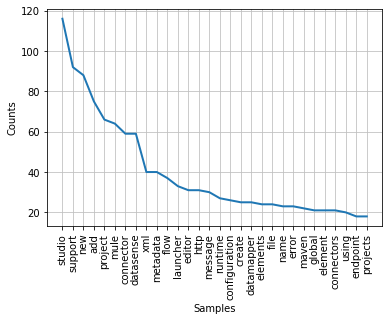

In [0]:
# Frequency Distribution of Words Plot
from nltk.probability import FreqDist
fdist = FreqDist(words)
import matplotlib.pyplot as plt
fdist.plot(30,cumulative=False)
plt.show()

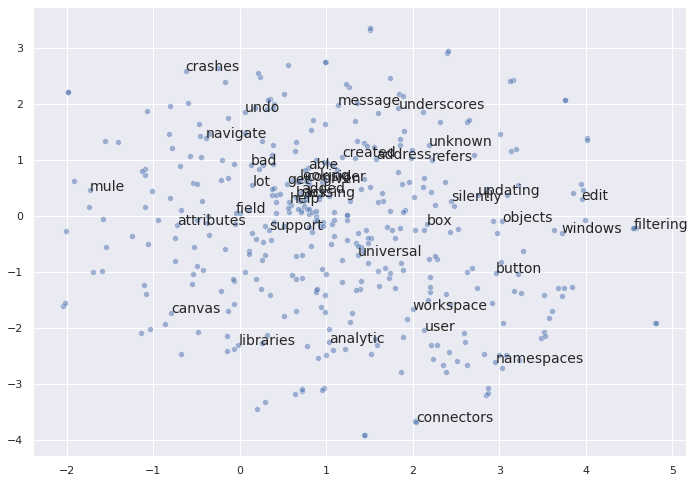

In [0]:
# Dimentionality Reduction
from sklearn.manifold import TSNE

# Initialize t-SNE
tsne = TSNE(n_components = 2, init = 'random', random_state = 10, perplexity = 100)
# Use only 400 rows to shorten processing time
tsne_df = tsne.fit_transform(df[:400])

# Plot
import seaborn as sns
sns.set()# Initialize figure
fig, ax = plt.subplots(figsize = (11.7, 8.27))
sns.scatterplot(tsne_df[:, 0], tsne_df[:, 1], alpha = 0.5)

# Import adjustText, initialize list of texts
#from adjustText import adjust_text
texts = []
words_to_plot = list(np.arange(0, 400, 10))

# Append words to list
for word in words_to_plot:
    texts.append(plt.text(tsne_df[word, 0], tsne_df[word, 1], df.index[word], fontsize = 14))
    
# Plot text using adjust_text (because overlapping text is hard to read)
'''
adjust_text(texts, force_points = 0.4, force_text = 0.4, 
            expand_points = (2,1), expand_text = (1,2),
            arrowprops = dict(arrowstyle = "-", color = 'black', lw = 0.5))
'''
plt.show()

In [0]:
raw_data['storypoint']

In [0]:
# Averaging Word Embeddings
def document_vector(word2vec_model, doc):
    # remove out-of-vocabulary words
    doc = [word for word in doc if word in model.vocab]
    return np.mean(model[doc], axis=0)

# Our earlier preprocessing was done when we were dealing only with word vectors
# Here, we need each document to remain a document 
def preprocess(text):
    text = text.lower()
    doc = word_tokenize(text)
    doc = [word for word in doc if word not in stop_words]
    doc = [word for word in doc if word.isalpha()] 
    return doc

# Function that will help us drop documents that have no word vectors in word2vec
def has_vector_representation(word2vec_model, doc):
    """check if at least one word of the document is in the
    word2vec dictionary"""
    return not all(word not in word2vec_model.vocab for word in doc)

# Filter out documents
def filter_docs(corpus, texts, condition_on_doc):
    """
    Filter corpus and texts given the function condition_on_doc which takes a doc. The document doc is kept if condition_on_doc(doc) is true.
    """
    number_of_docs = len(corpus)

    if texts is not None:
        texts = [text for (text, doc) in zip(texts, corpus)
                 if condition_on_doc(doc)]

    corpus = [doc for doc in corpus if condition_on_doc(doc)]

    print("{} docs removed".format(number_of_docs - len(corpus)))

    return (corpus, texts)

In [0]:
raw_data['storypoint'][0]

13

In [0]:
# Preprocess the corpus
def preprocessing(data_list):
  corpus = [preprocess(title) for title in data_list]

  # Remove docs that don't include any words in W2V's vocab
  corpus, data_list = filter_docs(corpus, data_list, lambda doc: has_vector_representation(model, doc))

  # Filter out any empty docs
  corpus, data_list = filter_docs(corpus, data_list, lambda doc: (len(doc) != 0))

  y = []
  x = []
  for doc in corpus: # append the vector for each document
      #print(corpus.index(doc))
      x.append(document_vector(model, doc))
      y.append(raw_data['storypoint'][corpus.index(doc)])
      
  X = np.array(x) # list to array
  y = np.array(y)
  return X, y


In [0]:
# Titles
X = preprocessing(titles_list)[0]
y = preprocessing(titles_list)[1]

0 docs removed
0 docs removed
0 docs removed
0 docs removed


In [0]:

# 80% of data goes to training
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 10)


XGBRegressor - using Titles of software issues/requests as data

In [0]:
from sklearn.metrics import mean_squared_error
import xgboost as xgb
# Instantiate an XGBRegressor
xgr = xgb.XGBRegressor(random_state=2)

# Fit the classifier to the training set
xgr.fit(X_train, y_train)

y_pred = xgr.predict(X_test)

mean_squared_error(y_test, y_pred)

# Accuracy
y_pred_rounded = [round(prediction,0) for prediction in y_pred ]
y_pred_rounded = [int(prediction) for prediction in y_pred_rounded]

from sklearn import metrics
acc_score = metrics.accuracy_score(y_test, y_pred_rounded)
print('Total accuracy classification score: {}'.format(acc_score))

[20:53:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Total accuracy classification score: 0.17006802721088435


GaussianNB - - using Titles of software issues/requests as data

In [0]:
# Build the classifier
from sklearn.naive_bayes import GaussianNB
clf = GaussianNB()

# Fit the classifier to the training set
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

# Accuracy
from sklearn import metrics
acc_score = metrics.accuracy_score(y_test, y_pred)
print('Total accuracy classification score: {}'.format(acc_score))


Total accuracy classification score: 0.1836734693877551


Using Descriptions of sotware issues/requests as data

In [0]:
# Descriptions
X = preprocessing(descriptions_list)[0]
y = preprocessing(descriptions_list)[1]

2 docs removed
0 docs removed
2 docs removed
0 docs removed


In [0]:

# 80% of data goes to training
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 10)


In [0]:
from sklearn.metrics import mean_squared_error
import xgboost as xgb
# Instantiate an XGBRegressor
xgr = xgb.XGBRegressor(random_state=2)

# Fit the classifier to the training set
xgr.fit(X_train, y_train)

y_pred = xgr.predict(X_test)

mean_squared_error(y_test, y_pred)

# Accuracy
y_pred_rounded = [round(prediction,0) for prediction in y_pred ]
y_pred_rounded = [int(prediction) for prediction in y_pred_rounded]

from sklearn import metrics
acc_score = metrics.accuracy_score(y_test, y_pred_rounded)
print('Total accuracy classification score: {}'.format(acc_score))

[20:53:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Total accuracy classification score: 0.14383561643835616


In [0]:
# Build the classifier
from sklearn.naive_bayes import GaussianNB
clf = GaussianNB()

# Fit the classifier to the training set
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

# Accuracy
from sklearn import metrics
acc_score = metrics.accuracy_score(y_test, y_pred)
print('Total accuracy classification score: {}'.format(acc_score))


Total accuracy classification score: 0.19863013698630136


In [0]:
y_pred, y_test

(array([ 5,  1,  3,  3,  1,  1, 13,  1,  3,  5, 34,  3,  1,  5,  8,  1,  5,
         1,  5, 34,  1,  5,  2, 34,  8,  1, 34,  1,  1,  1, 13, 34,  2,  1,
         1,  5,  1, 21, 13,  2,  5,  1, 21,  3,  1, 21,  1,  1, 34, 13,  1,
         2,  1,  1,  5,  5,  5,  5, 13, 21,  3,  5,  1,  5,  5,  1,  2,  5,
         1,  5,  1,  1,  3,  8,  1,  8,  5,  1,  5,  1,  1,  1,  1,  5,  5,
         1,  1,  2,  1, 21,  1, 13, 34, 34, 21, 21,  2, 21,  5,  1,  2,  3,
         1,  1,  1,  3,  3,  5,  5,  5, 21,  1,  1,  1,  5, 21, 34,  8,  5,
         8,  5,  2,  1, 34,  1,  2,  1,  1,  5, 21,  3,  1,  1,  1,  1,  1,
         2,  1,  1, 21,  1,  1, 21,  1,  1,  1]),
 array([13,  1,  8, 13,  5,  8, 13,  5,  5,  5,  3, 13,  5, 13,  8,  5,  5,
         1, 34,  3,  5,  2,  3, 13,  8,  2,  8,  5,  8,  2,  8,  8,  5,  8,
         3,  5,  1,  5,  5,  8,  2,  5, 21,  8,  1,  3, 13,  3,  8, 13,  3,
         8,  5,  8,  3, 13,  5,  5,  3,  5,  8,  8,  5,  1,  8,  8,  1,  3,
         8,  5, 21,  8,  1,  3,  8,  8